In [13]:
import function.functions as functions

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib
import sys

plt.rcParams['text.usetex'] = True
params = {
    "backend": "ps",
    "axes.labelsize": 22,
    "font.size": 22,
    "legend.fontsize": 10,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "legend.frameon": True,
    "savefig.dpi": 100,
    "axes.linewidth": 1.5,
    'xtick.major.size' : 10,
    'xtick.major.width': 1,
    'xtick.minor.size': 7,
    'xtick.minor.width': 1,
    'ytick.major.size' : 10,
    'ytick.major.width': 1,
    'ytick.minor.size': 7,
    'ytick.minor.width': 1,
    'axes.xmargin' : 0,
    'axes.ymargin' : 0,
}
plt.rcParams.update(params)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('text', usetex=True)

In [14]:
# Set device and parameters in this part

############################# Set parameters ##############################
device = 'fluxonium' # change here to change the device: charge_qubit, flopping_spin, flopping_charge, transmon, fluxonium

device_module = importlib.import_module('parameters.' + device)
globals().update(vars(device_module)) # import parameters of the device

########################### Parameters of the paper ###########################
if device == 'charge_qubit':
    wlist = np.linspace(0,2,101,endpoint=True)
    Alist = np.array([0.05*wq,0.5*wq,2.45*wq])
    
    ground, excited = 0, 1

elif device == 'flopping_spin':
    wlist = np.linspace(0,3*wq,151,endpoint=True)
    Alist = np.array([0.2*wq, 0.3*wq])
    
    ground, excited = 0, 1

elif device == 'transmon':
    wlist = np.linspace(0,2*wq,101,endpoint=True)
    Alist = np.array([0.052*wq, 0.09*wq])

    ground, excited = 0, 1

elif device == 'fluxonium':
    wlist = np.linspace(0,3*wq,101,endpoint=True)
    Alist = np.array([0.6*wq, 1.2*wq])

    ground, excited = 0, 1

else:
    print('select a valid device')
    sys.exit()
################################################################################

########################### Custom parameters #################################
# test other parameters A_q, ground, excited, w_r, w_r_disp, compensation
wlist = np.linspace(0,2*wq,11,endpoint=True)

save_file = True # test mode or save data to generate the data of the figure of the paper
################################################################################

In [15]:
g_parallel = np.zeros((len(wlist), len(Alist)), dtype=np.complex128)

for i,A_q in enumerate(Alist):
    A_list, dd_real = functions.get_derivatives(N_rep,A_q,H_sys,drive_op,wlist,n_states,num_A)[0], functions.get_derivatives(N_rep,A_q,H_sys,drive_op,wlist,n_states,num_A)[1]

    index_A = np.abs(A_list-A_q).argmin()

    print('derivatives of the spectrum computed in A_q/w_q='+str(A_list[index_A]/wq))
    
    g_parallel[:,i] = 1/2*g*(dd_real[:,index_A,1]-dd_real[:,index_A,0])

derivatives of the spectrum computed in A_q/w_q=0.5923076923076923
derivatives of the spectrum computed in A_q/w_q=1.1846153846153846


In [16]:
g_parallel_0 = np.zeros((len(wlist), len(Alist)))

for i,A_q in enumerate(Alist):

    if device == 'charge_qubit':
        g_parallel_0[:, i] = g*A_q*wq*np.ones(len(wlist))/((wq*np.ones(len(wlist)))**2-wlist**2)

    elif device == 'transmon':
        n01_modulo_squared = 1/2*np.sqrt(Ejeff/(8*EC))
        
        evals_analytical = np.zeros((len(wlist), n_states))
        evals_floquet_analytical = np.zeros((len(wlist), 2))

        for j in range(n_states):
            evals_analytical[:, j] = (-Ejeff + np.sqrt(8*Ejeff*EC)*(j+1/2) - EC/12*(6*j**2 + 6*j + 3))*np.ones(len(wlist))
            
        evals_floquet_analytical[:, 0] = evals_analytical[:,0] - n01_modulo_squared*wq*np.ones(len(wlist))/(wq**2*np.ones(len(wlist)) - wlist**2)
        evals_floquet_analytical[:, 1] = evals_analytical[:,1] + n01_modulo_squared*(wq*np.ones(len(wlist))/(wq**2*np.ones(len(wlist)) - wlist**2)*-2*(wq-EC)*np.ones(len(wlist))/((wq-EC)**2*np.ones(len(wlist))-wlist**2))

        g_parallel_0[:, i] = g*A_q/2*(n01_modulo_squared*(wq*np.ones(len(wlist))/(wq**2*np.ones(len(wlist)) - wlist**2)*-2*(wq-EC)*np.ones(len(wlist))/((wq-EC)**2*np.ones(len(wlist))-wlist**2))+n01_modulo_squared*wq*np.ones(len(wlist))/(wq**2*np.ones(len(wlist)) - wlist**2))

 /home/alessandro/python/venv/lib/python3.10/site-packages/matplotlib/cbook.py: 1699ComplexWarning: Casting complex values to real discards the imaginary part
 /home/alessandro/python/venv/lib/python3.10/site-packages/matplotlib/cbook.py: 1345

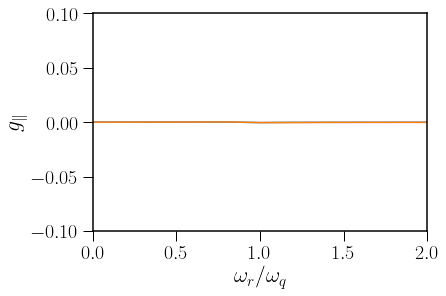

In [17]:
%matplotlib inline

import matplotlib.colors as mcolors
cmap = mpl.colormaps["tab10"]  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

fig, ax = plt.subplots()

for idx, A_q in enumerate(Alist):
    if g_parallel_0.any():
        ax.plot(wlist/wq, g_parallel[:,idx]/g_parallel_0[:,idx], color=colors[idx], label=r'$g_\parallel$')

    else:     
        ax.plot(wlist/wq, g_parallel[:,idx], color=colors[idx], label=r'$g_\parallel$')

ax.set_xlabel(r'$\omega_r/\omega_q$')

if g_parallel_0.any():
    ax.set_ylabel(r'$g_\parallel/g_\parallel^{(0)}$')
else:
    ax.set_ylabel(r'$g_\parallel$')

if g_parallel_0.any():
    ax.set_ylim(0,0.1)

else:
    ax.set_ylim(-0.1,0.1)

plt.show()

In [23]:
if save_file:
    fname = 'data/'+device+'/'+device+'_g_parallel'

    np.savez(fname, Alist=Alist, wlist=wlist, g_parallel=g_parallel, g_parallel_0=g_parallel_0)